In [1]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty, index_converter
from collections import defaultdict
import pickle
import math
from scipy.stats import linregress
import pingouin
plt.rcParams.update({'font.sans-serif':'Helvetica'})  # consistent figure formatting

### Main Measurement Quality Metric

In [14]:

def hidden_linreg(target, ref, num_hide=3, num_reps=10):
    # Main evaluation function for a gel lane -
    # hides a number of bands, attempts to linear fit the remaining bands and then predicts the value of the unseen bands

    # Initialize an empty list to store the selected sets
    selected_sets = set()
    
    # Loop to select unique sets
    for _ in range(num_reps):
        # Select the first num_hide numbers as a set
        selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        # Check if the set is already selected
        while selected_set in selected_sets:
            selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        selected_sets.add(selected_set)

    errors = []
    full_errors = []
    for combo in selected_sets:
        tfrac, rfrac = [t for ind, t in enumerate(target) if ind not in combo], [r for ind, r in enumerate(ref) if ind not in combo]
        slope, intercept, r_value, p_value, std_err = linregress(tfrac, rfrac)
        pred_hidden = [slope * target[sel_ind] + intercept for sel_ind in combo]
        ref_hidden = [ref[sel_ind] for sel_ind in combo]
        percentage_errors = [(np.abs(t-p)/t)*100 for t,p in zip(ref_hidden, pred_hidden)]
        errors.append(np.average(percentage_errors))
        full_errors.extend(percentage_errors)
    return errors, full_errors, (slope, intercept, combo)

def full_linreg(target, ref, num_hide=3, num_reps=10):
    # This function simply calculate linear regression on the full dataset, then computes the MAE and MAPE

    slope, intercept, r_value, p_value, std_err = linregress(target, ref)
    pred_values = [slope * t + intercept for t in target]
    errors = [np.abs(p-r) for p,r in zip(pred_values, ref)]
    percentage_errors = [(np.abs(r-p)/r)*100 for p, r in zip(pred_values, ref)]
    return errors, percentage_errors, (slope, intercept, combo)

In [4]:
# Full dataset loaded in here
data_pack = pickle.load(open('/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/combined_data_with_erosions_dilations_and_gelanalyzer.pkl','rb'))
for key,val in data_pack.items():
    data_pack[key]['Rectangularity'] = data_pack[key]['Pixel Count']/(data_pack[key]['Band Width']*data_pack[key]['Band Height'])
non_data_cols = ['Lane ID', 'Band ID', 'Rectangularity', 'Band Height', 'Band Width', 'Pixel Count', 'Ref.', 'Pixel STD']

In [6]:
# Additional GG-direct data loaded here (mainly to get global + local background correction)
def load_gg_csv_files_to_dict(folder_path, prefix="prefix_"):
    """
    Load CSV files from a folder and create a dictionary of DataFrames with prefixed keys.

    Parameters:
    - folder_path (str): The path to the folder containing CSV files.
    - prefix (str): The prefix to be added to the keys of the dictionary (default is "prefix_").

    Returns:
    - dataframes_dict (dict): A dictionary where keys are prefixed numbers, and values are corresponding DataFrames.
    """
    dataframes_dict = {}  # Dictionary to store DataFrames

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Extract the number from the filename
            file_number = filename.split("_")[0]

            # Read the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            dataframe = pd.read_csv(file_path)

            # Add the prefix to the number and use it as the key in the dictionary
            key = f"{prefix}{file_number}"
            dataframes_dict[key] = dataframe
    return dataframes_dict

gg_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/qupath_data/james_data_v3_fixed_global/Data_with_norm_and_corrections")
gg_dfs = load_gg_csv_files_to_dict(gg_path, "gg_") # loads data and converts to dictionary
gg_dfs = {key: gg_dfs[key] for key in sorted(gg_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])}  # sorts by gel ID

In [7]:
# combines GG-direct background corrected vals with the main data pack
for key, val in data_pack.items():
    gg_df = gg_dfs['gg_%s' % key.split('_')[0]][['Local Corrected Volume', 'Global Corrected Volume', 'Lane ID', 'Band ID']]
    data_pack[key] = pd.merge(val, gg_df, on=['Lane ID', 'Band ID'])

In [8]:
# example dataset from one gel
data_pack['0_Thermo'][data_pack['0_Thermo']['Lane ID'] == 12]

,Raw,RB Corrected,Lane ID,Band ID,Ref.,Pixel Count,Band Width,Band Height,Pixel Average,Pixel STD,...,dilation 1 BC,dilation 2,dilation 2 BC,random adjustment 1,random adjustment 1 BC,GA-Raw-Vol,GA-BC-Vol,Rectangularity,Local Corrected Volume,Global Corrected Volume
11,13406,8517,12,1,20,434,51,9,30.889401,6.124795,...,9488,17762,10012,10544,6960,337,181,0.945534,7129.462069,8229.284167
23,16358,11097,12,2,20,425,52,10,38.489412,9.072026,...,12208,21307,12752,19070,12208,420,233,0.817308,9752.509202,11288.635417
35,16314,10949,12,3,20,402,51,9,40.582090,8.709775,...,12295,21718,12974,12387,8582,429,232,0.875817,8841.154557,11518.977500
47,15671,10914,12,4,20,355,51,8,44.143662,7.425437,...,12603,21587,13476,18990,12603,446,233,0.870098,8470.185734,11436.589583
59,15581,10641,12,5,20,391,50,9,39.849105,6.858470,...,11840,20659,12537,15581,10641,447,220,0.868889,8888.061415,10917.184583
71,18032,12533,12,6,20,464,49,11,38.862069,9.096842,...,13506,22551,13989,14569,10462,441,266,0.860853,11167.793548,12497.446667
83,16598,11438,12,7,20,438,49,10,37.894977,7.268681,...,12577,21227,13131,13169,9346,410,242,0.893878,9974.283019,11373.572500
95,16440,11824,12,8,20,421,49,10,39.049881,7.085825,...,13298,21403,14011,19260,13298,416,260,0.859184,10010.181818,11418.347083
107,16617,12106,12,9,20,411,48,9,40.430657,7.855875,...,13733,21726,14559,16617,12106,424,260,0.951389,9996.390738,11714.626250
119,48661,41796,12,10,70,541,49,13,89.946396,19.401557,...,46256,58987,48684,54800,46256,1226,968,0.849294,34933.125000,42207.997083


In [9]:
# linear regression for dataset carried out here
# currently, all data except lane 2 of 14,15,16 are considered (the lane was impacted by the high-temp gel running and bands are not accurate)
blind_pred_dict = defaultdict(list)
all_error_dict = defaultdict(list)
descriptor_dict = defaultdict(list)
high_intensity = ['3_Thermo','4_Thermo', '6_Thermo', '7_Thermo','8_Thermo', '10_Thermo','11_Thermo', '12_Thermo', '17_NEB', '19_NEB', '20_NEB', '21_NEB', '24_NEB', '29_NEB', '31_NEB', '32_Thermo', '33_NEB']
low_intensity = ['0_Thermo','1_Thermo', '2_Thermo', '5_Thermo', '9_Thermo', '13_NEB', '14_NEB', '15_NEB', '16_NEB', '18_NEB', '22_NEB', '23_NEB', '34_Thermo' ]

np.random.seed(12)

for big_key in data_pack.keys():
    sel_df = data_pack[big_key]
    ladder_type = 'NEB'
    if 'Thermo' in big_key:
        ladder_type = 'ThermoFisher'
    for col_index, column in enumerate(sel_df.columns):
        if column in non_data_cols:
            continue
        if ' BC' in column and 'Raw' not in column:
            continue
        for lane in np.unique(sel_df['Lane ID']):

            if lane == 2 and big_key in ['14_NEB', '16_NEB', '17_NEB']:
                continue
            
            ref = sel_df[sel_df['Lane ID'] == lane]['Ref.'].to_numpy()
            target = sel_df[sel_df['Lane ID'] == lane][column].to_numpy()
            errors, full_errors, (slope, intercept, combo) = hidden_linreg(target, ref, 5, 80)
            blind_pred_dict[column].append(np.average(errors))
            all_error_dict[column].extend(full_errors)
            
            if column == 'Raw': # adds one time data for each lane e.g. rectangularity level, etc.
                rectangularity_sum = np.sum(sel_df[sel_df['Lane ID'] == lane]['Rectangularity'].to_numpy())/len(ref)
                descriptor_dict['Rectangularity'].append(rectangularity_sum)
    
                pixel_av = np.sum(sel_df[sel_df['Lane ID'] == lane]['Pixel Average'].to_numpy())/len(ref)
                if pixel_av > 255: # 16-bit norm
                    pixel_av = pixel_av/65535
                else: # 8-bit norm
                    pixel_av = pixel_av/255
                    
                descriptor_dict['Pixel Average'].append(pixel_av)
                descriptor_dict['Gel Name'].append(big_key)
                blind_pred_dict['Ladder'].append(ladder_type)
                if big_key in high_intensity:
                    descriptor_dict['Gel Intensity'].append('High')
                else:
                    descriptor_dict['Gel Intensity'].append('Low')


blind_df = pd.DataFrame.from_dict(blind_pred_dict)
blind_df_all = pd.DataFrame.from_dict(all_error_dict) # this isn't necessary, but nice to have
descriptor_df = pd.DataFrame.from_dict(descriptor_dict)

In [36]:
# linear regression for dataset carried out here
# currently, all data except lane 2 of 14,15,16 are considered (the lane was impacted by the high-temp gel running and bands are not accurate)
error_dict = defaultdict(list)
percentage_error_dict = defaultdict(list)
descriptor_dict = defaultdict(list)
high_intensity = ['3_Thermo','4_Thermo', '6_Thermo', '7_Thermo','8_Thermo', '10_Thermo','11_Thermo', '12_Thermo', '17_NEB', '19_NEB', '20_NEB', '21_NEB', '24_NEB', '29_NEB', '31_NEB', '32_Thermo', '33_NEB']
low_intensity = ['0_Thermo','1_Thermo', '2_Thermo', '5_Thermo', '9_Thermo', '13_NEB', '14_NEB', '15_NEB', '16_NEB', '18_NEB', '22_NEB', '23_NEB', '34_Thermo' ]

np.random.seed(12)

for big_key in data_pack.keys():
    sel_df = data_pack[big_key]
    ladder_type = 'NEB'
    if 'Thermo' in big_key:
        ladder_type = 'ThermoFisher'
    for col_index, column in enumerate(sel_df.columns):
        if column in non_data_cols:
            continue
        if ' BC' in column and 'Raw' not in column:
            continue
        for lane in np.unique(sel_df['Lane ID']):

            if lane == 2 and big_key in ['14_NEB', '16_NEB', '17_NEB']:
                continue
            
            ref = sel_df[sel_df['Lane ID'] == lane]['Ref.'].to_numpy()
            target = sel_df[sel_df['Lane ID'] == lane][column].to_numpy()
            errors, percentage_errors, (slope, intercept, combo) = full_linreg(target, ref)
            
            error_dict[column].extend(errors)
            percentage_error_dict[column].extend(full_errors)
            if column == 'Raw': # adds one time data for each lane e.g. rectangularity level, etc.
                rectangularity_sum = np.sum(sel_df[sel_df['Lane ID'] == lane]['Rectangularity'].to_numpy())/len(ref)
                descriptor_dict['Rectangularity'].append(rectangularity_sum)
    
                pixel_av = np.sum(sel_df[sel_df['Lane ID'] == lane]['Pixel Average'].to_numpy())/len(ref)
                if pixel_av > 255: # 16-bit norm
                    pixel_av = pixel_av/65535
                else: # 8-bit norm
                    pixel_av = pixel_av/255
                    
                descriptor_dict['Pixel Average'].append(pixel_av)
                descriptor_dict['Gel Name'].append(big_key)
                error_dict['Ladder'].extend(ladder_type*len(errors))

                if big_key in high_intensity:
                    descriptor_dict['Gel Intensity'].append('High')
                else:
                    descriptor_dict['Gel Intensity'].append('Low')

error_df = pd.DataFrame.from_dict(error_dict)
perc_error_df = pd.DataFrame.from_dict(percentage_error_dict) # this isn't necessary, but nice to have
descriptor_df = pd.DataFrame.from_dict(descriptor_dict)

ValueError: All arrays must be of the same length

In [37]:
len(error_dict['Ladder'])

43362

In [23]:
error_dict['Raw']

[2.2633556475833068,
 4.2232454788035305,
 2.2878219962468798,
 2.301897803392748,
 3.073721228557762,
 4.551680978873751,
 4.073103535914289,
 2.2244808640904807,
 0.2702896386726721,
 0.34004905433920385,
 0.7966474159232177,
 4.493892759570834,
 1.310414376747346,
 0.9393687987336605,
 3.6442697385976857,
 2.797375341988044,
 5.166802878208916,
 14.455974617342655,
 3.527154343451542,
 3.108248208211915,
 2.3084659805411967,
 1.6923546714343942,
 2.278241652169921,
 4.224223409612918,
 4.442768553220613,
 3.2942440751120827,
 1.913224763378345,
 0.3555858933662961,
 2.2266955829926047,
 3.3938196477911546,
 0.6178313343061603,
 0.9398840509827409,
 3.153234867094728,
 1.611794120159594,
 5.533981963416863,
 14.378482640299577,
 4.06185515447908,
 2.8654288492905735,
 1.846915793348611,
 0.714459495988482,
 2.205023123519986,
 4.195541789927109,
 5.130341444010828,
 3.3374794208801113,
 2.537551358679117,
 0.903844974494433,
 2.599437187585224,
 4.169063472427283,
 0.7507662298823483

## Plot 1 - Comparing GA vs GG

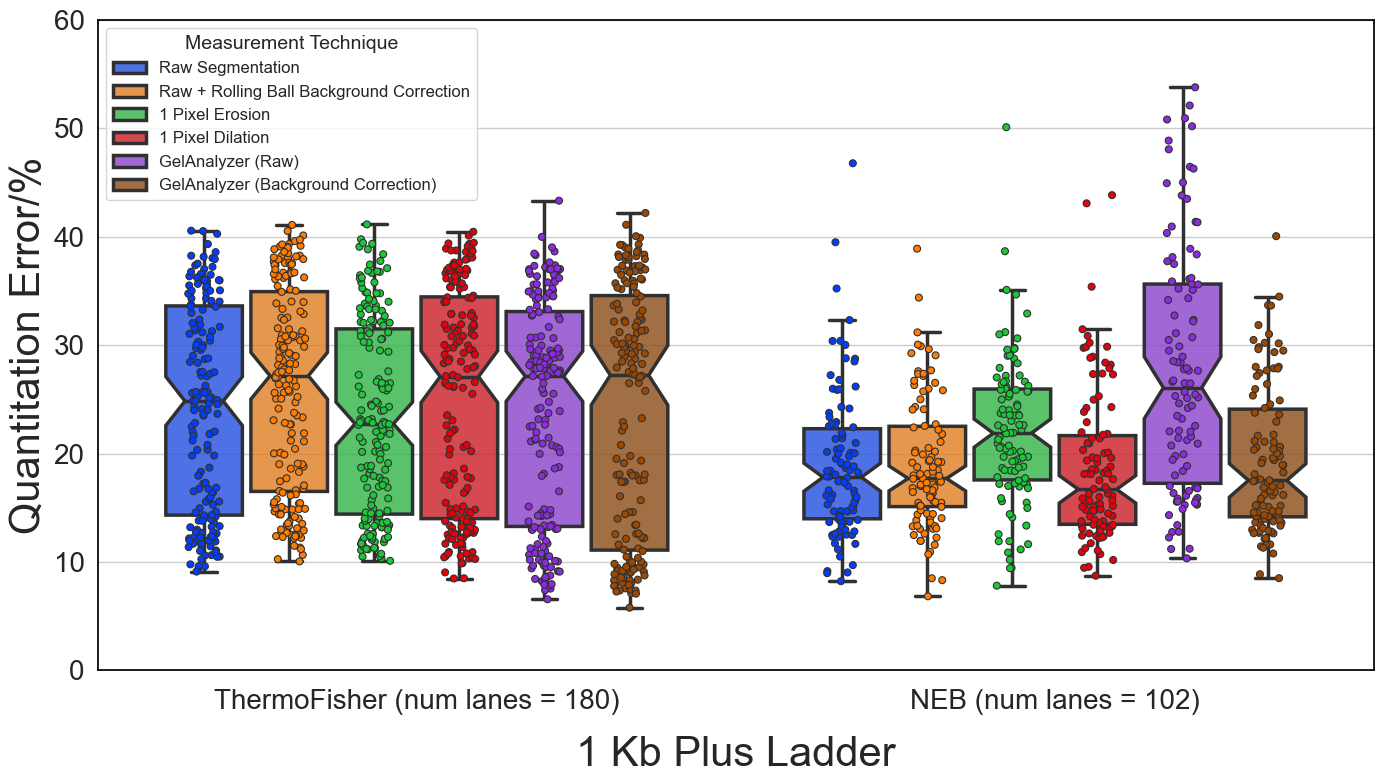

In [10]:
# for now, random adjustment and additional erosion/dilation are unneccessary.  Will add these to supp info.
df_adjusted = blind_df.drop(columns=['Pixel Average', 'random adjustment 1', 'erosion 2', 'dilation 2', 'Local Corrected Volume', 'Global Corrected Volume'])
df_adjusted.rename(columns={"Raw":"Raw Segmentation", "RB Corrected":"Raw + Rolling Ball Background Correction", "erosion 1":"1 Pixel Erosion", "dilation 1":"1 Pixel Dilation", "GA-Raw-Vol":"GelAnalyzer (Raw)", "GA-BC-Vol":"GelAnalyzer (Background Correction)"}, inplace=True)
df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
plt.figure(figsize=(14,8))

sel_palette = "bright"
sns.set(style="whitegrid")
# ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, 
                 notch=True, gap=.4, widths=[0.12, 0.12], palette=sel_palette, linewidth=2.5)
ax.tick_params(axis='x', labelsize=20, size=10)
ax.set_xticks(ax.get_xticks()) # just to silence annoying warning
ax.set_xticklabels(['ThermoFisher (num lanes = %s)' % sum(blind_df["Ladder"] == "ThermoFisher"),'NEB (num lanes = %s)' % sum(blind_df["Ladder"] == "NEB")])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
# sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark") 
sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True, 
              alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8) 

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# sns.despine(offset=10, trim=False)
plt.xlabel('1 Kb Plus Ladder', fontsize=30, labelpad=15)
plt.ylabel('Quantitation Error/%', fontsize=30)
plt.yticks(fontsize=20)
plt.ylim([0,60])
ax.legend(title='Measurement Technique', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ladder_comp_seg_human_dataset.pdf')
pass

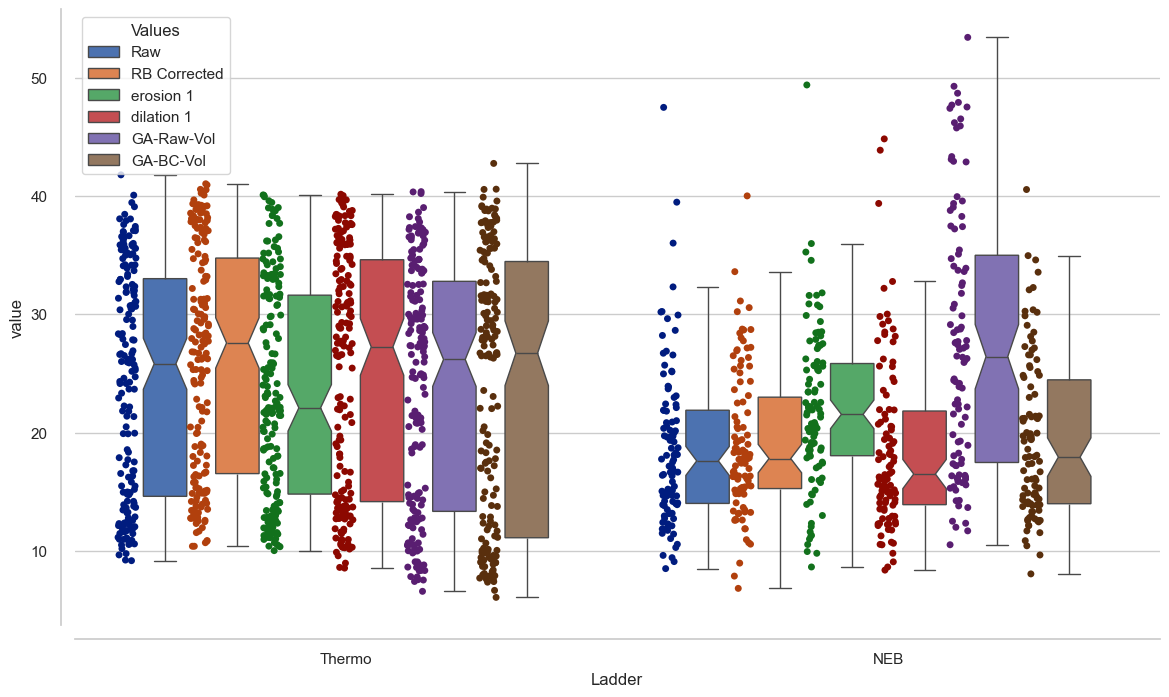

In [365]:
# alternative visualization - other version preferred
import matplotlib
df_melted = pd.melt(blind_df.drop(columns=['Pixel Average', 'random adjustment 1', 'erosion 2', 'dilation 2']), id_vars=['Ladder'], var_name='Values')

plt.figure(figsize=(14,8))
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, notch=True, gap=.4, saturation=1.5)
stripplot = sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, marker="o", palette="dark") 
sns.despine(offset=10, trim=False)

# Adjust stripplot positions
for i, artist in enumerate(stripplot.get_children()):
    if isinstance(artist, matplotlib.collections.PathCollection):
        new_pos = [p - 0.07  for p in artist.get_offsets()[:, 0]]
        artist.set_offsets(list(zip(new_pos, artist.get_offsets()[:, 1])))

pass

## Plot 2 - Comparing Background Correction Methods

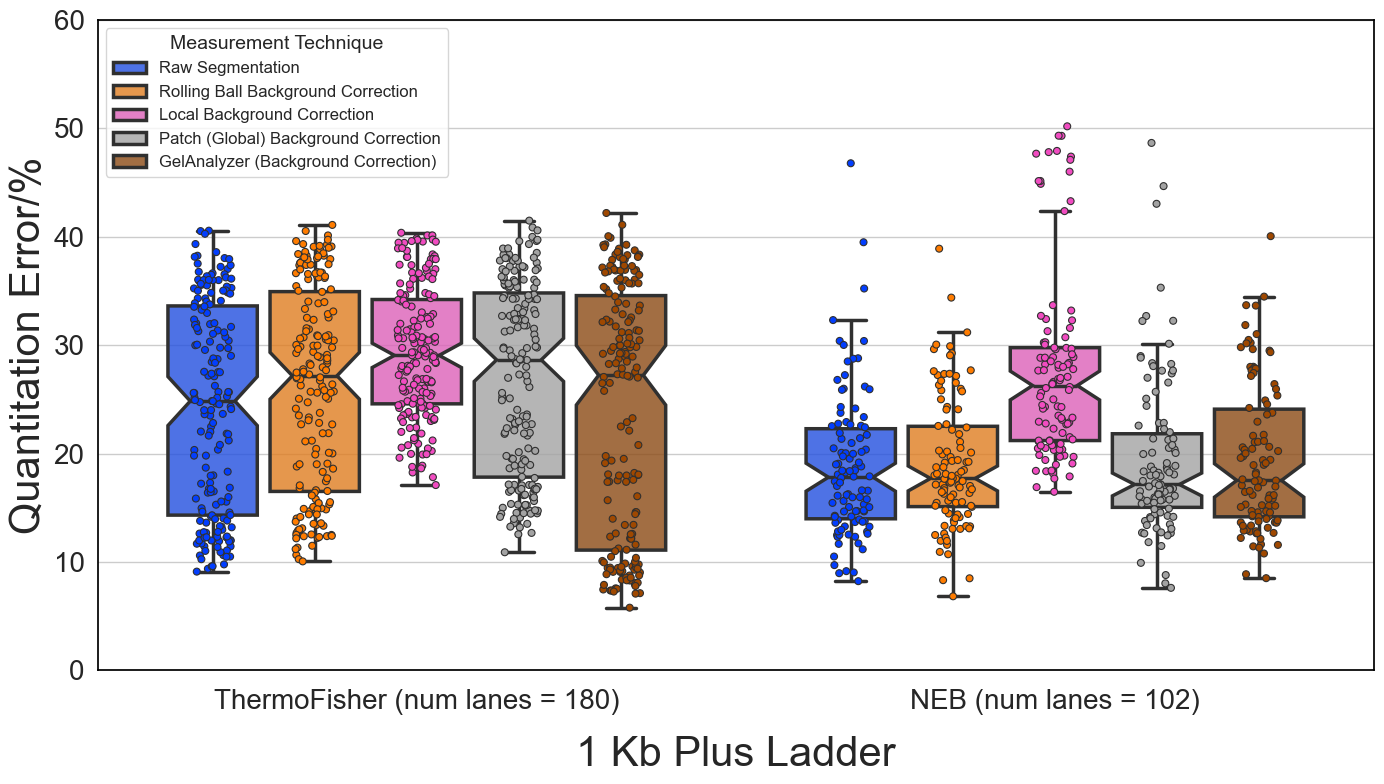

In [501]:

# for now, random adjustment and additional erosion/dilation are unneccessary.  Will add these to supp info.
df_adjusted = blind_df.drop(columns=['Pixel Average', 'random adjustment 1', 'erosion 2', 'dilation 2', 'erosion 1', 'dilation 1', 'GA-Raw-Vol', 'GA-BC-Vol'])
df_adjusted['GA-BC-Vol'] = blind_df['GA-BC-Vol']
df_adjusted.rename(columns={"Raw":"Raw Segmentation", "RB Corrected":"Rolling Ball Background Correction", "Local Corrected Volume":"Local Background Correction", "Global Corrected Volume":"Patch (Global) Background Correction", "GA-BC-Vol":"GelAnalyzer (Background Correction)"}, inplace=True)
df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
plt.figure(figsize=(14,8))

sel_palette = ['#023eff', '#ff7c00', '#f14cc1', '#a3a3a3', '#9f4800']
sns.set(style="whitegrid")
# ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, 
                 notch=True, gap=.4, widths=[0.14, 0.14], palette=sel_palette, linewidth=2.5)
ax.tick_params(axis='x', labelsize=20, size=10)
ax.set_xticks(ax.get_xticks()) # just to silence annoying warning
ax.set_xticklabels(['ThermoFisher (num lanes = %s)' % sum(blind_df["Ladder"] == "ThermoFisher"),'NEB (num lanes = %s)' % sum(blind_df["Ladder"] == "NEB")])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
# sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark") 
sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True, 
              alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8) 

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# sns.despine(offset=10, trim=False)
plt.xlabel('1 Kb Plus Ladder', fontsize=30, labelpad=15)
plt.ylabel('Quantitation Error/%', fontsize=30)
plt.yticks(fontsize=20)
plt.ylim([0,60])
ax.legend(title='Measurement Technique', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ladder_comp_seg_human_dataset_background_correction.pdf')
pass

### Individual Gel Testing

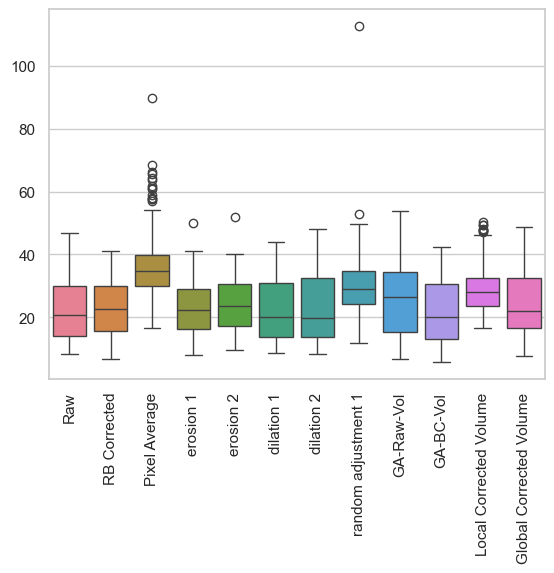

In [500]:
ax = sns.boxplot(data=blind_df)
ax.tick_params(axis='x', rotation=90)

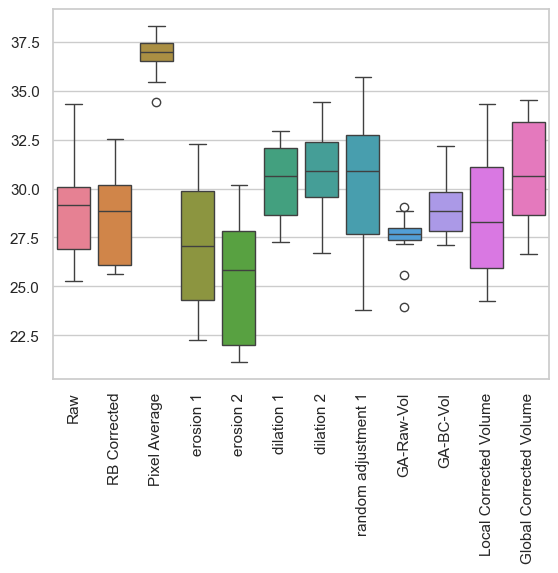

In [508]:
ax = sns.boxplot(data=blind_df[descriptor_df['Gel Name'] == '5_Thermo'])
ax.tick_params(axis='x', rotation=90)

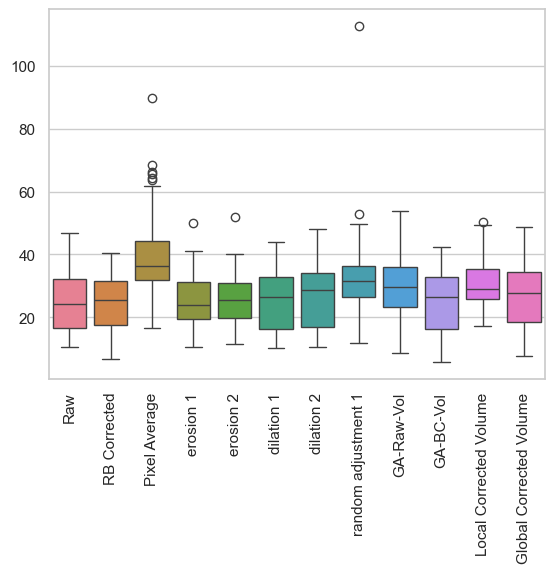

In [479]:
ax = sns.boxplot(data=blind_df[descriptor_df['Gel Intensity'] == 'High'])
ax.tick_params(axis='x', rotation=90)

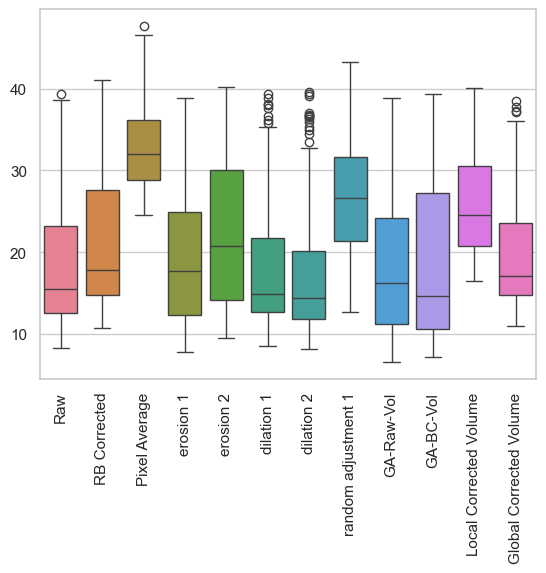

In [480]:
ax = sns.boxplot(data=blind_df[descriptor_df['Gel Intensity'] == 'Low'])
ax.tick_params(axis='x', rotation=90)

## Stat Testing (t-test with paired samples)

In [175]:
pingouin.ttest(blind_df['Raw'], blind_df['erosion 1'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.955978,281,two-sided,0.051458,"[-0.85, 0.0]",0.047755,0.438,0.125767


In [177]:
pingouin.ttest(blind_df['Raw'], blind_df['erosion 2'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.851995,281,two-sided,0.000145,"[-2.76, -0.89]",0.211013,85.718,0.941956


In [176]:
pingouin.ttest(blind_df['Raw'], blind_df['dilation 1'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.403874,281,two-sided,0.000761,"[-0.83, -0.22]",0.055059,18.418,0.151491


In [180]:
pingouin.ttest(blind_df['Raw'], blind_df['Pixel Average'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-17.401831,281,two-sided,1.581204e-46,"[-15.66, -12.48]",1.455341,1.287e+43,1.0


In [191]:
pingouin.ttest(blind_df['Raw'], blind_df['GA-Raw-Vol'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.943182,281,two-sided,2.657899e-11,"[-3.65, -2.04]",0.287457,2.484e+08,0.997819


In [190]:
pingouin.ttest(blind_df['Raw'], blind_df['GA-BC-Vol'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.726487,281,two-sided,0.468145,"[-0.38, 0.83]",0.02321,0.087,0.067457


In [185]:
pingouin.ttest(blind_df['erosion 1'], blind_df['GA-BC-Vol'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.743327,281,two-sided,0.457905,"[-0.51, 1.12]",0.032383,0.088,0.084269


In [186]:
pingouin.ttest(blind_df['Raw'], blind_df['RB Corrected'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.102652,281,two-sided,6.175942e-07,"[-1.93, -0.86]",0.153253,1.51e+04,0.727342


In [524]:
print(sns.color_palette('bright').as_hex())
sns.color_palette('bright')

['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff']


[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

## SHOWING INDIVIDUAL LINEAR PLOTS

0 2


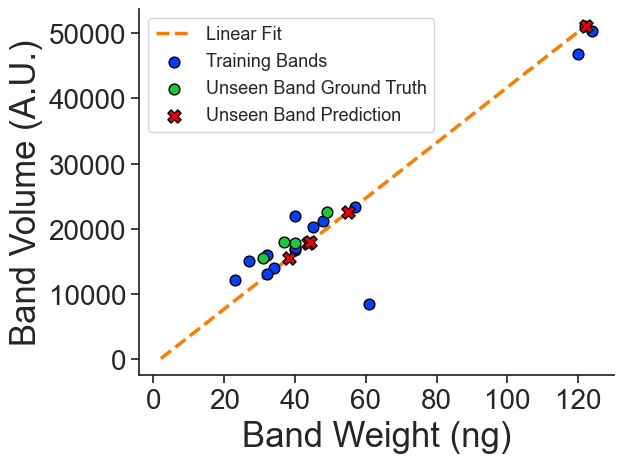

0 3


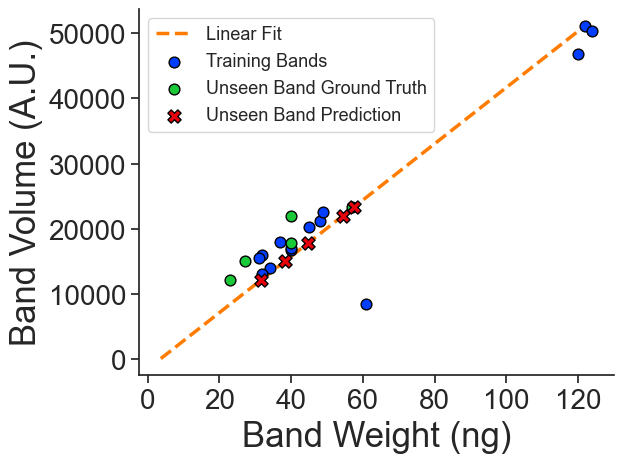

0 4


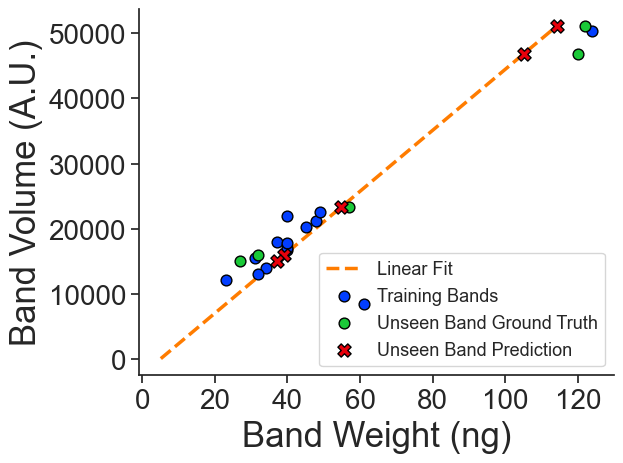

In [652]:
sel_df = data_pack['23_NEB']
lane = 2
ref = sel_df[sel_df['Lane ID'] == lane]['Ref.'].to_numpy()
target = sel_df[sel_df['Lane ID'] == lane][column].to_numpy()
np.random.seed(12)
sns.set(style="ticks")

for lane in [2,3,4]:
    for i in range(10):
        selected_sets = set()
        num_hide = 5
         
        # Select the first num_hide numbers as a set
        selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        # Check if the set is already selected
        while selected_set in selected_sets:
            selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        selected_sets.add(selected_set)
        combo = next(iter(selected_sets))
    
        tfrac, rfrac = [t for ind, t in enumerate(target) if ind not in combo], [r for ind, r in enumerate(ref) if ind not in combo]
        linreg_result = linregress(tfrac, rfrac)
        slope = linreg_result.slope
        intercept = linreg_result.intercept
    
        pred_hidden = [slope * target[sel_ind] + intercept for sel_ind in combo]
        ref_hidden = [ref[sel_ind] for sel_ind in combo]
        target_hidden = [target[sel_ind] for sel_ind in combo]
        fig, ax = plt.subplots()
    
        y_data = range(0,int(np.max(target)))
        x_data = slope*y_data + intercept
        
        sns.lineplot(x=x_data, y=y_data, 
                     linestyle='dashed', c='#ff7c00', label='Linear Fit', linewidth=2.5, zorder=5)
        
        plt.scatter(rfrac, tfrac, c='#023eff', label='Training Bands',edgecolors='black', linewidth=1, zorder=6, s=60)
        plt.scatter(ref_hidden, target_hidden,c='#1ac938', label='Unseen Band Ground Truth',edgecolors='black', 
                    linewidth=1, zorder=7, s=60)
        plt.scatter(pred_hidden, target_hidden, c='#e8000b', label='Unseen Band Prediction',edgecolors='black', 
                    linewidth=1, marker='X', zorder=8, s=90)
    
    
        # sns.regplot(x=rfrac, y=tfrac)
        plt.legend(fontsize=13)
        plt.xlabel('Band Weight (ng)', fontsize=25)
        plt.ylabel('Band Volume (A.U.)', fontsize=25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        plt.tight_layout()
        # plt.savefig('/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/manuscript/figures/metric_plots/human_seg_analysis/linear_plots/%s_%s.pdf' % (lane, i), dpi=300)
        plt.show()
        plt.close()
        break

    
    
    
    # plt.ylim([0,70000])
    

### Qualitative GA VS GG

In [642]:
gg_quality_file = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/full_test_set_eval/metrics/qualitative_bands_identified.csv'
ga_quality_file = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/full_test_set_eval/gelanalyzer_projects_for_test_set/qualitative_bands_identified.csv'

gg_qual = pd.read_csv(gg_quality_file)
ga_qual = pd.read_csv(ga_quality_file)

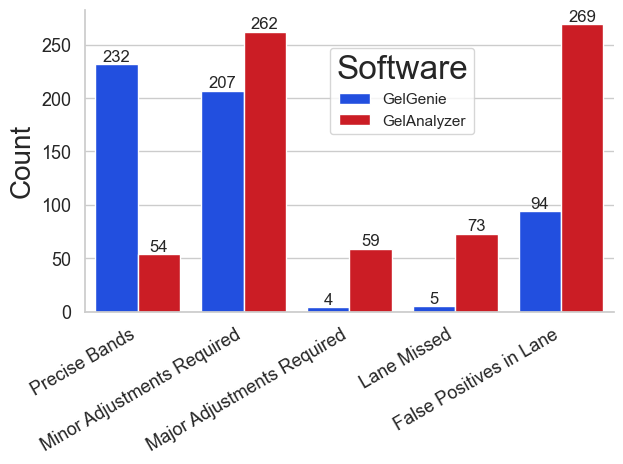

In [743]:

gg_qual_counts = defaultdict(int)
ga_qual_counts = defaultdict(int)

for code in gg_qual[' Lane Codes']:
    for qualcode, newname in zip(['P', 'Bn', 'L', 'Bo', 'M'],['Precise Bands', 'Minor Adjustments Required', 'Lane Width Needs Adjustment','Major Adjustments Required', 'Lane Missed']):
        gg_qual_counts[newname] += code.count(qualcode)
    
for code in ga_qual[' Lane Codes']:
    for qualcode, newname in zip(['P', 'Bn', 'L', 'Bo', 'M'],['Precise Bands', 'Minor Adjustments Required', 'Lane Width Needs Adjustment','Major Adjustments Required', 'Lane Missed']):
        ga_qual_counts[newname] += code.count(qualcode)

ga_qual_counts['Minor Adjustments Required'] += ga_qual_counts['Lane Width Needs Adjustment']
gg_qual_counts['Minor Adjustments Required'] += gg_qual_counts['Lane Width Needs Adjustment']

ga_qual_counts.pop('Lane Width Needs Adjustment', None)
gg_qual_counts.pop('Lane Width Needs Adjustment', None)

gg_qual_counts['False Positives in Lane'] = sum(gg_qual[' Lanes with additional Bands'])   
ga_qual_counts['False Positives in Lane'] = sum(ga_qual[' Lanes with additional Bands'])   

# Convert dictionaries to pandas DataFrames
df1 = pd.DataFrame(list(gg_qual_counts.items()), columns=['Keys', 'GelGenie'])
df2 = pd.DataFrame(list(ga_qual_counts.items()), columns=['Keys', 'GelAnalyzer'])

merged_df = pd.merge(df1, df2, on='Keys')

# Melt the DataFrame to convert it to long format
melted_df = pd.melt(merged_df, id_vars=['Keys'], var_name='Software', value_name='Count')

# Plot using Seaborn
ax = sns.barplot(data=melted_df, x='Keys', y='Count', hue='Software', palette=['#023eff', '#e8000b'])
ax.bar_label(ax.containers[0], fontsize=12);
ax.bar_label(ax.containers[1], fontsize=12);

plt.ylabel('Count', fontsize=20)
plt.xlabel('')
plt.xticks(rotation=30, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
# for legend text
plt.setp(ax.get_legend().get_texts(), fontsize='20')  
 
# for legend title
plt.setp(ax.get_legend().get_title(), fontsize='24') 

sns.move_legend(ax, "upper center", bbox_to_anchor=(0.6, 0.9))
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/qual_bar_chart.pdf')
plt.show()

In [678]:
merged_df

,Keys,GelGenie,GelAnalyzer
0,Precise Bands,232,54
1,Minor Adjustments Required,207,262
2,Major Adjustments Required,4,59
3,Lane Missed,5,73
4,False Positives in Lane,94,269


### Test Set Dice Score

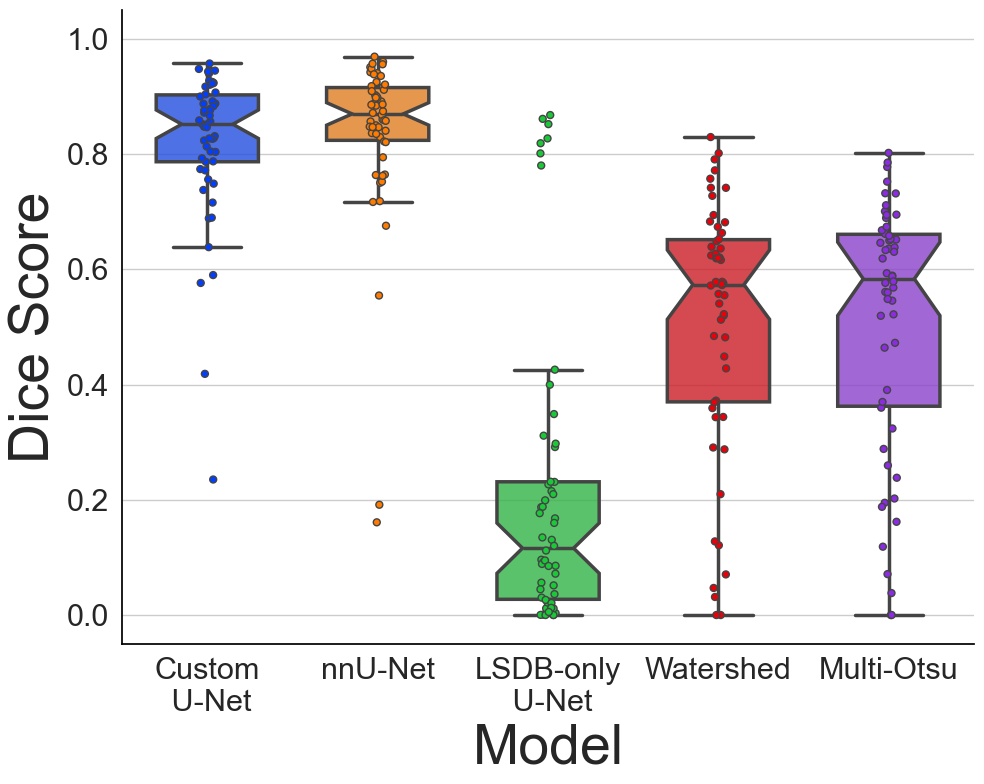

In [742]:
# fixed terms
metrics = ['Dice Score', 'MultiClass Dice Score', 'True Negatives', 'False Positives', 'False Negatives','True Positives']
data_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/full_test_set_eval'
output_folder = '/Users/matt/Desktop'

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Helvetica'
title_fontsize = 20
axis_fontsize = 40
tick_fontsize = 22
label_fontsize = 22
metric_of_interest = 'Dice Score' # just dice score is required

# images corresponding to each dataset
dataset_titles = ['Matthew Gels 1', 'Matthew Gels 2', 'Nathan Gels', 'LSDB Gels', 'Quantitation Gels']
mg_1 = ['8', '13', '38', '62', '81', '105', '108', '114', '128', '132', '140', '143', '146', '161', '168', '179', '183',
        '187', '205', '214', '220', '230', '235', '242', '251', '257', '263', '292', '307', '312']
mg_2 = ['0', '7', '11', '32', '49', '176', '201', '216', 'mg2_214']
ng = ['UVP01944May172019', 'UVP01947May172019', 'UVP01949May172019', 'UVP02164June252019']
lsdb = ['C50-4', 'C30194', 'C51416', 'C53007', 'C60248', 'C61344', 'E864']
quantg = ['1_Thermo', '8_Thermo', '25_NEB', '29_NEB']
selection = mg_1 + mg_2 + ng + quantg + lsdb # just put in all gels from the test set

# loading and gathering datasets
datasets = {}
for m in metrics:
    datasets[m] = pd.read_csv(os.path.join(data_folder, 'metrics', m + '.csv'), index_col=0)

# custom name for each column/model
models = datasets[m].columns
custom_names = ['Old U-Net', 'Custom\n U-Net', 'Custom U-Net\n (Extended)', 'LSDB-only\n U-Net',
                'LSDB-only U-Net\n (Extended)', 'Watershed', 'Multi-Otsu', 'nnU-Net', 'nnU-Net\n (Extended)']

# actual data for plotting
zoom_slice = [1, 7, 3, 5, 6]
tick_points = [0, 0.2, 0.4, 0.6, 0.8, 1]
zoom_names = [custom_names[i] for i in zoom_slice]
zoom_columns = [models[i] for i in zoom_slice]
target_df = datasets[metric_of_interest].iloc[:, zoom_slice]

sns.set(style="whitegrid")
sel_palette = 'bright'

# box plots for selective figures

fig, ax = plt.subplots(figsize=(10,8))

# [x.set_linewidth(2.5) for x in ax.spines.values()]  # makes border thicker

# Set the color of the spines to black
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

melted_df_models = pd.melt(target_df.loc[selection].reset_index(), id_vars=['Image'], var_name='model', value_name='value')

boxplot = sns.boxplot(x='model', y='value', data=melted_df_models, showfliers=False,hue='model',legend=False,widths=[0.6],
                      notch=True, palette=sel_palette, linewidth=2.5)

for patch in boxplot.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
    
sns.stripplot(x='model', y='value', data=melted_df_models, jitter=0.05, legend=False, dodge=False, hue='model',
          alpha=1.0, marker="o", palette=sel_palette, linewidth=1.0)

# plt.title('All Gels (n=54)', fontsize=title_fontsize)  # seems to overlap with figure, making tiny for now then will replace in post
# Set font size for ticks
boxplot.tick_params(axis='x', labelsize=tick_fontsize)
boxplot.tick_params(axis='y', labelsize=tick_fontsize)

# Add labels and title
plt.xlabel('Model', fontsize=axis_fontsize)
plt.ylabel('Dice Score', fontsize=axis_fontsize)
plt.yticks(tick_points, fontsize=tick_fontsize)
ax.set_ylim(-0.05, 1.05)

ax.set_xticks(ax.get_xticks())  # just to silence annoying warning

boxplot.set_xticklabels(zoom_names, fontsize=label_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, f'dice_score_test_set_boxplot.pdf'), dpi=300)
plt.show()


### Other Tests

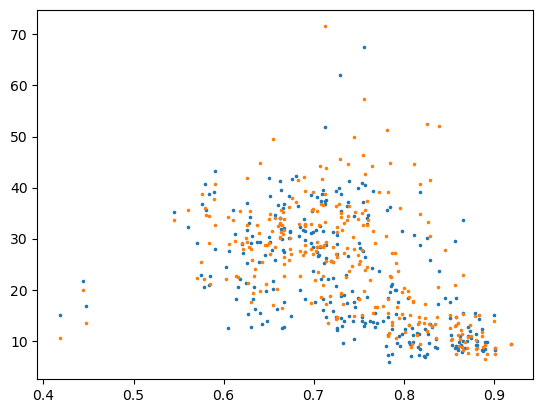

In [119]:
scat_size = 2.5
# plt.scatter(descriptor_df['Rectangularity'], blind_df['Raw'],s=scat_size)
# plt.scatter(descriptor_df['Rectangularity'], blind_df['RB Corrected'],s=scat_size)
plt.scatter(descriptor_df['Rectangularity'], blind_df['GA-BC-Vol'],s=scat_size)
plt.scatter(descriptor_df['Rectangularity'], blind_df['GA-Raw-Vol'],s=scat_size)
# plt.scatter(descriptor_df['Rectangularity'], blind_df['random adjustment 1'],s=scat_size)

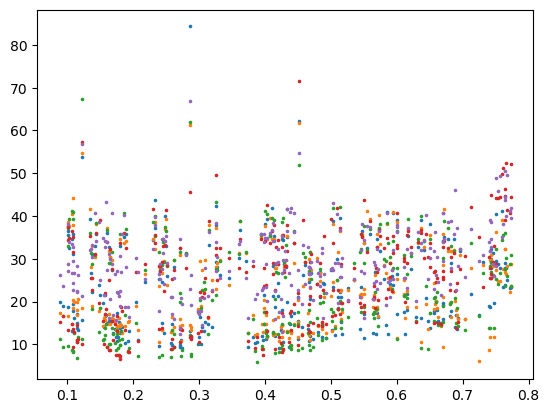

In [137]:
scat_size = 2.5
plt.scatter(descriptor_df['Pixel Average'], blind_df['Raw'],s=scat_size)
plt.scatter(descriptor_df['Pixel Average'], blind_df['RB Corrected'],s=scat_size)
plt.scatter(descriptor_df['Pixel Average'], blind_df['GA-BC-Vol'],s=scat_size)
plt.scatter(descriptor_df['Pixel Average'], blind_df['GA-Raw-Vol'],s=scat_size)
plt.scatter(descriptor_df['Pixel Average'], blind_df['random adjustment 1'],s=scat_size)